[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/floleuerer/ml-tutorials/blob/main/02_fastai_imgscraper.ipynb)

# Vorbereitung

Laufzeit-Typ ändern. Python-Pakete von fast.ai installieren und importieren.

In [55]:
!pip install -Uq fastai

OSError: [Errno 12] Cannot allocate memory

In [56]:
from fastai.vision.all import *

**Wichtig!** Wenn die folgende Zelle "False" ausgibt, ist keine GPU vorhanden -> Bitte prüfe die Schritte in Notebook 01 noch einmal und starte ggf. das Notebook neu. Bei "True" hast du eine GPU-Instanz und kannst weiter machen.

In [3]:
torch.cuda.is_available()

True

# Einen Eigenen Bilder-Klassifizierer bauen

Im ersten Notebook haben wir gesehen, wir man mit einem Standard-Datensatz einfach und schnell ein Image-Classification Model zu trainieren. Das Wissen möchten wir jetzt nutzen um ein eigenes kleines Projekt umzusetzen.

Dazu erstellen wir uns mit hilfe von der Suchmaschine DuckDuckGo einen eigenen Datensatz und trainieren damit ein Classification-Model.

# Eigenen Datensatz erstellen


Um Bilder von DuckDuckGo herunterladen zu können installieren und importieren wir die Python-Bibliothek JMD_ImageScraper.

In [4]:
!pip install -q jmd_imagescraper

In [5]:
from jmd_imagescraper.core import *
from pathlib import Path

Den Pfad als `path`-Variable speichern und anschließend den Datensatz herunterladen. `duckduckgo_search()` benötigt den Destination-Pfad, ein Label, einen Suchbegriff und die Anzahl der gewünschten Ergebnisse.

In [6]:
path = Path().cwd()/"test_images"

Ordner `path` löschen falls er bereits existiert

In [7]:
if path.exists():
    import shutil
    shutil.rmtree(path)

Jetzt wird es interssant! 

`n_images` - Anzahl der Bilder, die pro search term heruntergeladen werden

`search_terms` - Liste von Suchbegriffen, zu denen Bilder von DuckDuckGo heruntergeladen werden

Hier findest du drei Beispiellisten für Suchbegriffe. Du kannst entweder diese Beispiele verwenden oder einfach eigene Suchbegriffe verwenden.

In [8]:
n_images = 100
search_terms = ["tacos", "burger", "french fries", "cheesecake","pizza","hot dog"]
#search_terms = ["adidas superstars", "nike air jordan", "converse all star", "new balance 574"]
#search_terms = ["grizzly bear", "black bear", "teddy bear"]

Hier wird für jeden Suchbegriff die oben definierte Anzahl an Bildern heruntergeladen.

In [9]:
for term in search_terms:
    duckduckgo_search(path, '_'.join(term.split()), term, max_results=n_images)

Duckduckgo search: tacos


Duckduckgo search: burger


Duckduckgo search: french fries


Duckduckgo search: cheescake


Duckduckgo search: pizza


Duckduckgo search: hot dog


Jetzt können wir übprüfen, ob und wie viele Bilder geladen wurden:

In [38]:
files = get_image_files(path)
len(files)

597

# Data Block API

Anders als im ersten Beispiel erzeugen wir unser DataLoaders Objekt diesmal mit Hilfe der fast.ai Data Block API. Diese vereinfachen das Zusammenbringen des Datensets und des DataLoaders und werden in Blöcken zusammengefasst.

Bei der Erzeugung eines DataBlock werden Informationen für den DataLoader mitgegeben.

In [42]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 get_y=parent_label,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 item_tfms=Resize(224))

`blocks` ImageBlock definiert, dass der Input ein Bild ist und CategoryBlock das Label.

`get_image_files` lädt alle Bilder aus einem Ordner

`get_y=parent_label` legt fest, dass das Label dem Namen des Ordners entspricht, in welchem Sie sich befinden.

`RandomSplitter` teilt die Daten in verschiedene Datensätze auf. Einer dient als Trainingsdatensatz und ein weiterer zur Validierung. Der Valdierungsdatensatz wird dabei im Training nicht verwendet, sondern genutzt, um zu schauen, wie das Modell performt.

`Resize` skaliert jedes Bild auf eine Größe von 224x244

Der DataLoader wird nun aus dem DataBlock erzeugt. Anschließend überprüfen wir mit `dls.vocab` unsere Labels und lassen uns einen Batch anzeigen.

In [43]:
dls = dblock.dataloaders(path)

In [44]:
dls.vocab

['burger', 'cheescake', 'french_fries', 'hot_dog', 'pizza', 'tacos']

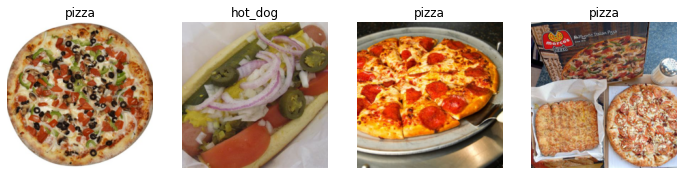

In [45]:
dls.show_batch(max_n=4, nrows=1)

# Data Transformation & Augmentation

Es ist gängige Praxis die Bilder zu verkleinern und in eine einheitliche Form zu bringen. Dies kann dazu führen, dass einige wichtige Details verloren gehen. fast.ai bietet deshalb Funktionen zum Skalieren der Bilder ohne dabei Informationen zu verlieren.


`RandomResizedCrop()` schneidet das Bild auf einen zufällig ausgewählten Teil zu, welcher sich in jeder Epoche ändert. Dadurch lernt das Modell, sich auf verschiedene Merkmale des Bildes zu konzentrieren und diese zu erkennen. 

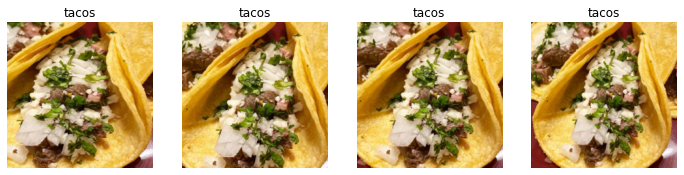

In [46]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5))
dls = dblock.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

`aug_transforms()` erstellt zufällige Variationen der Eingabedaten, so dass diese unterschiedlich aussehen, aber keine wichtigen Daten verloren gehen. Gängige Data Augmentation Techniken für Bilder sind das Rotieren, Spiegeln, Verzerren und das Ändern der Helligkeit oder des Kontrasts. Dadurch wird die Diversität der Daten erhöht.

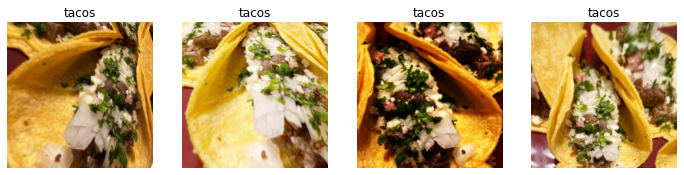

In [47]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms(mult=2))
dls = dblock.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Modell trainieren

Diesmal nutzen wir ein Resnet34-Modell zum finetunen.

In [48]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.676374,1.113538,0.621849,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.157197,0.425795,0.831933,00:04
1,0.881927,0.231955,0.890756,00:04
2,0.675554,0.217131,0.899160,00:04
3,0.572572,0.216999,0.907563,00:04


Neben der accuracy werden auch immer train und valid loss angezeigt. Das Loss beschreibt, wie gut die Berechnung des Modells ist. Dies ergibt sich aus der Summe der Fehler je Item. Es wird dabei das Trainings- und das Validation-Datenset unterschieden, deren größe wir im Datablock festgelegt haben.

# Ergebnisse anzeigen und interpretieren

`learn.show_results()` zeigt Beispielbilder und deren Klassifizierung an (rot bedeutet, dass das Modell das Bild falsch klassifiziert hat).

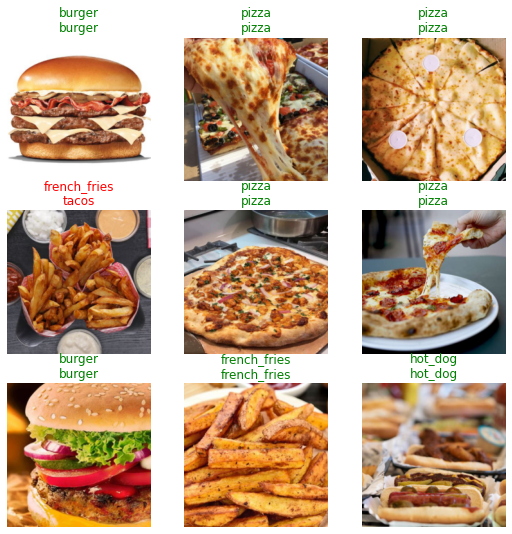

In [49]:
learn.show_results()

Um genauer zu untersuchen wo das Modell Fehler macht, kann man sich die Bilder mit dem höchsten `loss` anzeigen lassen. Ein hohes `loss` bedeutet, dass ein Bild entweder falsch klassifiziert wurde oder das Modell sich bei der richtigen Klassifizierung unsicher war. Bei den folgenden Bildern hatte das Modell also Schwierigkeiten eine korrekte Entscheidung zu treffen.

In [50]:
interp = ClassificationInterpretation.from_learner(learn)

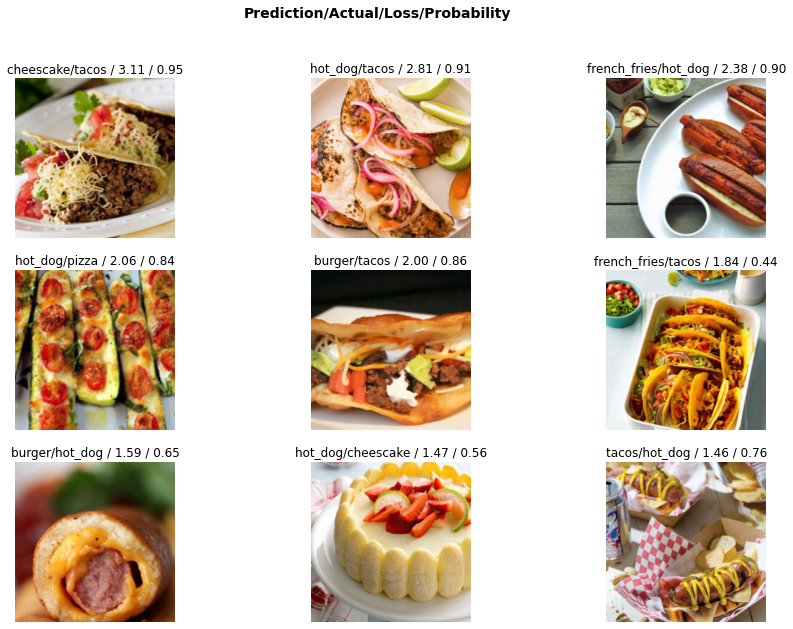

In [51]:
interp.plot_top_losses(9, figsize=(15,10))

Mit der `Confusion Matrix` sieht man, wieviele Bilder "verwechselt" also falsch Klassifiziert wurden und welche Klassen davon betroffen sind.

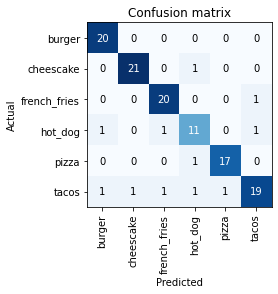

In [52]:
interp.plot_confusion_matrix()

# Bereinigen der Daten

An den top_losses erkennt man, dass sich noch einige fehlerhafte Daten im Datensatz befinden, wodurch die Genauigkeit des Models noch beeinflusst wird. Die ImageScraper Bibliothek enthält einen cleaner, der es uns erlaubt unseren Datensatz zu bereinigen.

Sieh dir die Bilder innerhalb der verschiedenen Kategorien an und wähle bei unpassenden Bildern `<Delete>` im Drop-Down-Menü unterhalb des Bildes aus. Das Label kann über das obere Drop-Down gewechselt werden. Es wird außerdem zwischen dem Trainings- und dem Validation-Datenset unterschieden. Diese kannst du im unteren Drop-Down wechseln. Die Bilder sind nach den `top-losses` sortiert, um die Suche nach fehlerhaften Daten zu vereinfachen. Es sollten nur Bilder gelöscht werden, die eindeutig nicht diesem Label zugeordnet sein sollten. 

Es ist auch möglich, die Kategorie eines Bildes zu ändern, falls z. B. das Bild einer Pizza dem Label Cheesecake zugeordnet ist.

**Achtung:** Beim Wechsel der Kategorie geht der Fortschritt verloren, führe daher immer die Löschung bzw. Umordnung der Daten durch, bevor du die Kategorie wechselst.

In [54]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn, max_n=100)
cleaner

In [ ]:
## Löschung/Umordnung

In [ ]:
Jetzt können die fehlerhaften Bilder gelöscht und die falsch sortierte Bilder umgeordnet werden.

In [35]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
    print(cleaner.fns[idx])
for idx in cleaner.change():
    print(cleaner.fns[idx])
    shutil.copyfile(cleaner.fns[idx], path/cat)

/home/jupyter/ml-tutorials/test_images/hot_dog/086_2eba5be0.jpg
/home/jupyter/ml-tutorials/test_images/hot_dog/084_ddf027f6.jpg
/home/jupyter/ml-tutorials/test_images/hot_dog/078_2b3f905b.jpg


Bereinige den Datensatz und starte erneut bei der Erzeugung des DataBlocks (Abschnitt: Data Block API). Du wirst sehen, dass die Genauigkeit des Models jetzt zunehmen wird. 

Überprüfe, ob die gewünschte Anzahl an Bildern gelöscht wurde. Sie sollte sich im Vergleich zum Beginn verringert haben.

In [ ]:
files = get_image_files(path)
len(files)